# Measure the location of misclassifications
When the performance of a segmentation algorithm is evaluated it is often done by counting the number of misclassified pixels as number of false positive and false negative. This gives a global number that doesn't tell how the misclassifications are distributed in the image. the two extremes would be randomly distributed over the image or it could be as highly correlated to the ground truth. In the later case it would be that the item sizes are over- or under-estimated. The function ```misclassification_distance``` creates a histogram showing the distribution of misclassifications as function of the distance from the item edge.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
import skimage.morphology as morph 

import sys
sys.path.append('../')
import amglib.metrics as metrics
import amglib.plotsupport as ps

In [48]:
import importlib
importlib.reload(metrics)
importlib.reload(ps)

<module 'amglib.plotsupport' from '/Users/kaestner/git/scripts/python/notebooks/../amglib/plotsupport.py'>

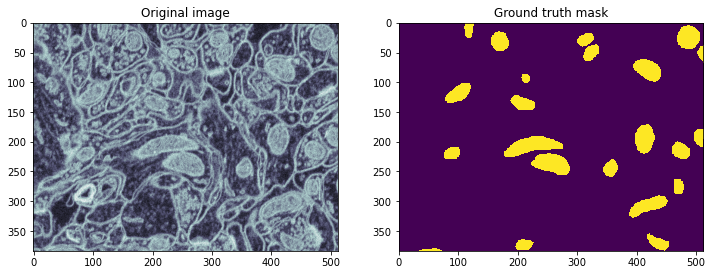

In [49]:
cell_img = (255-io.imread("/Users/kaestner/lectures/Quantitative-Big-Imaging-2022/Lectures/Lecture-04/data/em_image.png")[::2, ::2])/255.0
cell_seg = io.imread("/Users/kaestner/lectures/Quantitative-Big-Imaging-2022/Lectures/Lecture-04/data/em_image_seg.png")[::2, ::2]>0

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(cell_img, cmap='bone')
ax[0].set_title('Original image')
ax[1].imshow(cell_seg,interpolation='none')
ax[1].set_title('Ground truth mask');

## A simple case - overgrown items
In this example, we look at a case where the items were to generously segmented. This is demonstrated using a dilation operation.

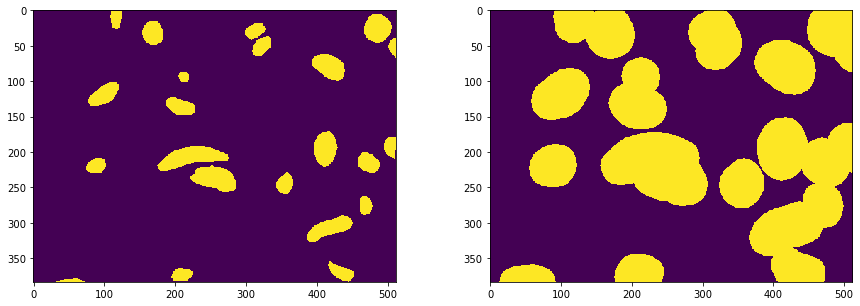

In [50]:
grown=morph.dilation(cell_seg,selem=morph.disk(20))

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(cell_seg,interpolation='none')
ax[1].imshow(grown,interpolation='none')

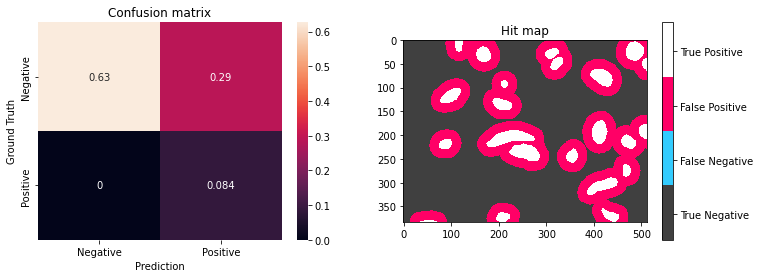

In [51]:
ps.showHitMap(cell_seg,grown)

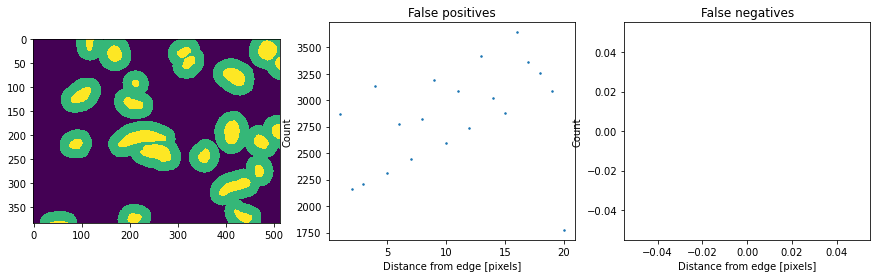

In [52]:
res=metrics.misclasification_distance(cell_seg,grown)

fig,ax=plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(res['confusion_map'],interpolation='none')
ax[1].plot(res['fp_dist'][1:],res['fp_count'][1:],'.',markersize=3)
ax[1].set_xlabel('Distance from edge [pixels]')
ax[1].set_ylabel('Count')
ax[1].set_title('False positives')
ax[2].plot(res['fn_dist'][1:],res['fn_count'][1:],'.',markersize=3)
ax[2].set_xlabel('Distance from edge [pixels]')
ax[2].set_ylabel('Count')
ax[2].set_title('False negatives');

Text(0, 0.5, 'Fraction of misclassified pixels')

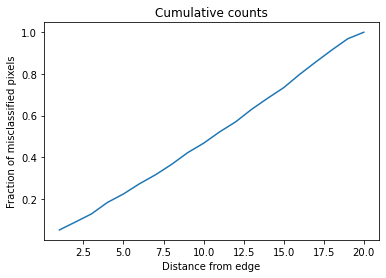

In [56]:
cfpd=np.cumsum(res['fp_count'][1:])
cfpd=cfpd/cfpd[-1]


plt.plot(res['fp_dist'][1:],cfpd, label='False positives')
plt.title('Cumulative counts')
plt.xlabel('Distance from edge')
plt.ylabel('Fraction of misclassified pixels')

Here, you can see that the misclassified pixels are relatively close to the true items. The number of misclassified pixels increases slightly with the distance. This increase is due to the inceasing perimeter size of the objects.

## A more complicated case
In this example we apply a threshold to the cell image and a first inspection shows that there are quite many misclassified pixels.

We start with segmenting the image using an Otsu threshold

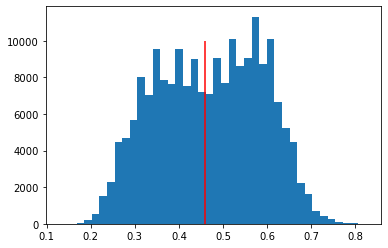

In [57]:
plt.hist(cell_img.ravel(),bins=40);
th = flt.threshold_otsu(cell_img)
plt.vlines([th],ymin=0,ymax=10000,color='red')

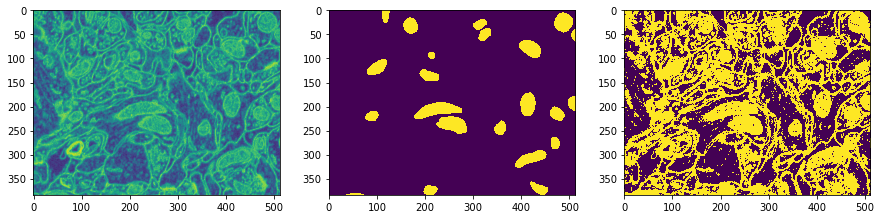

In [58]:
cell_th = th < cell_img
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(cell_img)
ax[1].imshow(cell_seg,interpolation='none')
ax[2].imshow(cell_th,interpolation='none')

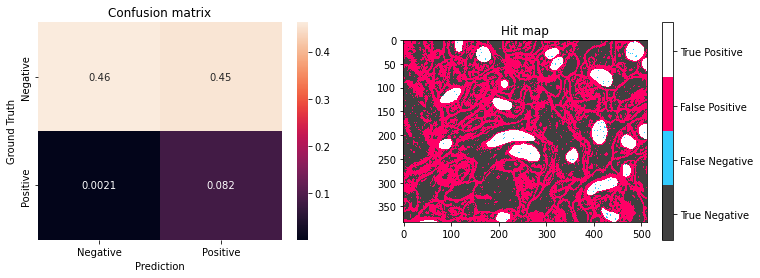

In [59]:
ps.showHitMap(cell_seg,cell_th)

As you can see here, the confusion matrix tells us that there is something wrong with this result, but it is not until we look at the hit map that we see how the hits are distributed. The hit map is good for qualitative assessments, but we want to know how far away from the items we misclassify pixels in the image. This is where we can use the misclassification distance.

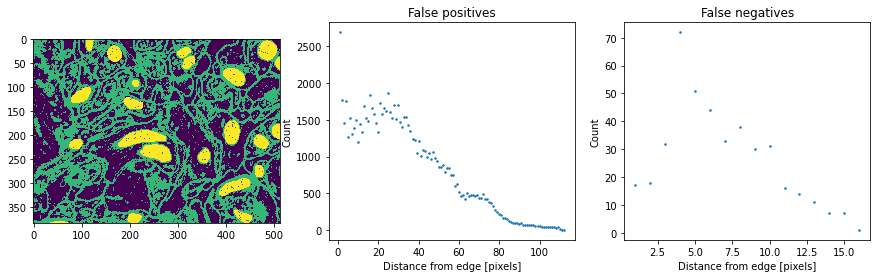

In [60]:
res=metrics.misclasification_distance(cell_seg,cell_th)

fig,ax=plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(res['confusion_map'],interpolation='none')
ax[1].plot(res['fp_dist'][1:],res['fp_count'][1:],'.',markersize=3)
ax[1].set_xlabel('Distance from edge [pixels]')
ax[1].set_ylabel('Count')
ax[1].set_title('False positives')
ax[2].plot(res['fn_dist'][1:],res['fn_count'][1:],'.',markersize=3)
ax[2].set_xlabel('Distance from edge [pixels]')
ax[2].set_ylabel('Count')
ax[2].set_title('False negatives');

Ideally, this plot should have high counts for short distances and relatively soon the should hardly be any counts at all. So, the conclusion here is that there is a wide spatial spread of the detected pixel using this segmenation method.

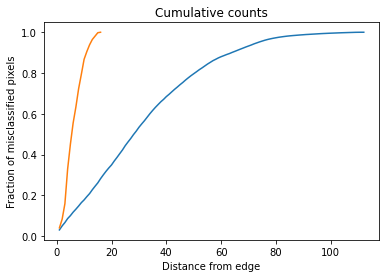

In [62]:
cfpd=np.cumsum(res['fp_count'][1:])
cfpd=cfpd/cfpd[-1]
cfnd=np.cumsum(res['fn_count'][1:])
cfnd=cfnd/cfnd[-1]

plt.plot(res['fp_dist'][1:],cfpd, label='False positives')
plt.plot(res['fn_dist'][1:],cfnd, label='False negatives');
plt.title('Cumulative counts')
plt.xlabel('Distance from edge')
plt.ylabel('Fraction of misclassified pixels');